In [ ]:
For my counterfeit drug detection project, I sourced the dataset from Kaggle, specifically from the following link: https://www.kaggle.com/datasets/vencerlanz09/pharmaceutical-drugs-and-vitamins-dataset-v2. This dataset was chosen for its relevance, as it contains a comprehensive collection of images of pharmaceutical drugs, which are integral to my project's focus on distinguishing between genuine and counterfeit drugs.

Kaggle is a reputable platform for data science and machine learning, known for hosting high-quality, legally-sourced datasets. The chosen dataset is tailored for image classification tasks and includes diverse images of pharmaceutical drugs and vitamins, making it an ideal fit for the project. By using this dataset, I adhered to conventional methods of data collection in machine learning, ensuring both the ethical and legal integrity of my project. The dataset's structure and labeling system align with standard practices in machine learning, facilitating effective model training and evaluation.

In summary, the selection of this specific dataset from Kaggle underscores a commitment to using approved and reliable sources for data collection, which is crucial in the field of machine learning, especially for academic and research-oriented projects.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

In [2]:
# Define paths
base_dataset_path = r"C:\Users\Hp\OneDrive\Desktop\Machine Learning\Summative\dataset\images"
main_train_dir = os.path.join(base_dataset_path, 'train1')  # Path to training images directory
main_test_dir = os.path.join(base_dataset_path, 'test1')    # Path to testing images directory
# Other paths
train_csv_file_path = os.path.join(base_dataset_path, 'train1.csv')
test_csv_file_path = os.path.join(base_dataset_path, 'test1.csv')

In [3]:
# Load VGG16 model without the top layer
model_vgg = VGG16(weights='imagenet', include_top=False)

# Data Preprocessing




*preprocess_image(img_path):

Loads an image from the given path and resizes it to 224x224 pixels, the input size expected by the VGG16 model.
Converts the image to a numpy array format, which is suitable for processing by neural networks.
Adds an extra dimension to the array to represent the batch size, a requirement for model input.
Applies VGG16-specific preprocessing to the image data, such as pixel value scaling and normalization.
Returns the preprocessed image data.

*extract_vgg_features(img_data):

Uses the VGG16 model (model_vgg) to predict and extract features from the preprocessed image data.
Flattens the extracted features to create a one-dimensional array. This is useful for feeding these features into fully connected layers later.
Returns the flattened feature array.

*process_images_from_csv(csv_file_path, image_directory):

Reads a CSV file containing image data (like filenames and labels) from the given file path.
Uses the LabelEncoder to convert textual labels into a binary format. This is necessary for binary classification tasks.
Initializes empty lists to store features and labels.
Iterates over each row in the DataFrame, processes each image using the previously defined functions, and appends the extracted features and labels to their respective lists.
Returns the features and labels as numpy arrays, along with the label encoder.

*Processing the Data:

Calls process_images_from_csv for both training and testing datasets, passing the paths to the respective CSV files and image directories.
train_features and test_features will store the VGG16-extracted features for each image in the training and testing datasets, respectively.
train_labels and test_labels will store the corresponding labels.
The label encoder, returned from processing the training data, is used to ensure consistent label encoding across both datasets.

In [4]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)  # Apply VGG16 preprocessing
    return img_data

def extract_vgg_features(img_data):
    vgg_features = model_vgg.predict(img_data)
    return vgg_features.flatten()

def process_images_from_csv(csv_file_path, image_directory):
    df = pd.read_csv(csv_file_path)
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])  # Convert textual labels to binary
    all_features = []
    all_labels = []

    for index, row in df.iterrows():
        image_path = os.path.join(image_directory, row['filename'])
        img_data = preprocess_image(image_path)
        features = extract_vgg_features(img_data)
        all_features.append(features)
        all_labels.append(row['label'])

    return np.array(all_features), np.array(all_labels), label_encoder

# Process data
train_features, train_labels, label_encoder = process_images_from_csv(train_csv_file_path, main_train_dir)
test_features, test_labels, _ = process_images_from_csv(test_csv_file_path, main_test_dir)

1/1 [==============================] - 0s 290ms/step


In [5]:
# Process data
train_features, train_labels, label_encoder = process_images_from_csv(train_csv_file_path, main_train_dir)
test_features, test_labels, _ = process_images_from_csv(test_csv_file_path, main_test_dir)

1/1 [==============================] - 1s 657ms/step


### Addressing Class Imbalances 

The purpose of computing class weights is to address the issue of class imbalance in training datasets. Class imbalance occurs when certain classes are underrepresented compared to others, which can lead the model to become biased towards the majority class.
The computed class weights can be used during the training of your model. By applying these weights, the model gives more importance to the minority classes, helping to improve the model's performance and its ability to generalize.

In [6]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(train_labels), 
                                                  y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Model Creation and Training 

In [7]:
# # Model architecture
# def create_model(input_shape):
#     model = Sequential()
#     model.add(Dense(256, activation='relu', input_shape=input_shape))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# model = create_model(train_features.shape[1:])


# Define the function to create a neural network model
def create_model(input_shape):
    # Initialize a Sequential model
    model = Sequential()

    # Add a fully connected layer with 256 neurons and ReLU activation
    model.add(Dense(256, activation='relu', input_shape=input_shape))

    # Add a Dropout layer to reduce overfitting; it drops 50% of the neurons
    model.add(Dropout(0.5))

    # Add the output layer with a single neuron (for binary classification) and sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with Adam optimizer and binary cross-entropy loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model using the shape of training features (excluding the batch size)
model = create_model(train_features.shape[1:])

In [8]:
# Train the model with class weights to handle imbalance
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(test_features, test_labels),
    class_weight=class_weight_dict
)

Epoch 1/20


7/7 [==============================] - 6s 331ms/step - loss: 19.4365 - accuracy: 0.4950 - val_loss: 7.1244 - val_accuracy: 0.5806
Epoch 2/20
7/7 [==============================] - 1s 130ms/step - loss: 6.8047 - accuracy: 0.7950 - val_loss: 9.5470 - val_accuracy: 0.4153
Epoch 3/20
7/7 [==============================] - 1s 159ms/step - loss: 3.2764 - accuracy: 0.8600 - val_loss: 5.2117 - val_accuracy: 0.5847
Epoch 4/20
7/7 [==============================] - 1s 128ms/step - loss: 2.2597 - accuracy: 0.9300 - val_loss: 4.8304 - val_accuracy: 0.4395
Epoch 5/20
7/7 [==============================] - 1s 166ms/step - loss: 0.9135 - accuracy: 0.9350 - val_loss: 7.2358 - val_accuracy: 0.4032
Epoch 6/20
7/7 [==============================] - 1s 156ms/step - loss: 0.1763 - accuracy: 0.9750 - val_loss: 5.1485 - val_accuracy: 0.4194
Epoch 7/20
7/7 [==============================] - 1s 128ms/step - loss: 0.2995 - accuracy: 0.9750 - val_loss: 4.6111 - val_accuracy: 0.4556
Epoch 8/20
7/7 [=

# Model Evaluation

In [9]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_features, test_labels)
print("Test Accuracy: ", test_accuracy)

# Confusion Matrix and Classification Report
predicted_classes = (model.predict(test_features) > 0.5).astype(int)
print(confusion_matrix(test_labels, predicted_classes))
print(classification_report(test_labels, predicted_classes))

8/8 [==============================] - 0s 11ms/step - loss: 4.6894 - accuracy: 0.4476
Test Accuracy:  0.44758063554763794
8/8 [==============================] - 0s 8ms/step
[[ 88  13]
 [124  23]]
              precision    recall  f1-score   support

           0       0.42      0.87      0.56       101
           1       0.64      0.16      0.25       147

    accuracy                           0.45       248
   macro avg       0.53      0.51      0.41       248
weighted avg       0.55      0.45      0.38       248



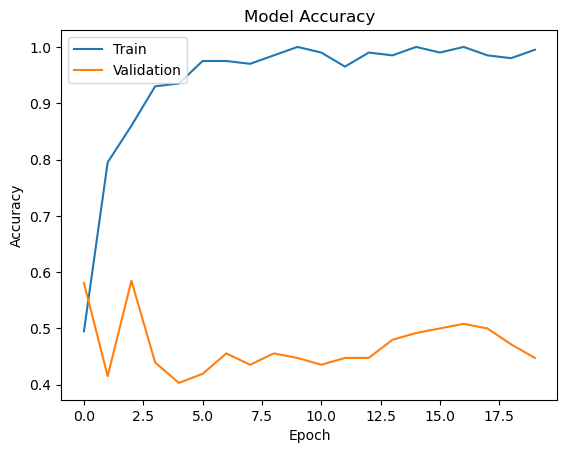

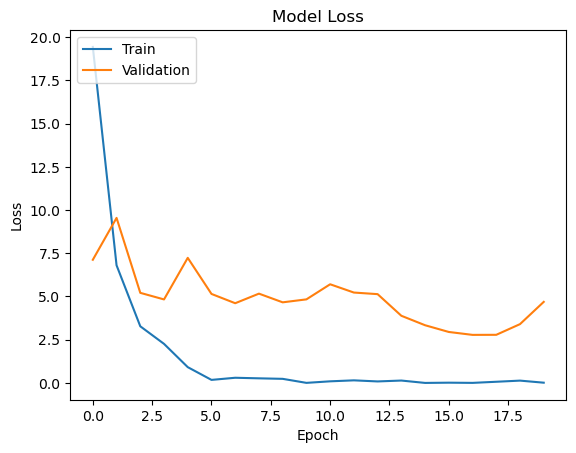

In [10]:
# Plot Accuracy and Loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
# Predict on the test set
predicted_probabilities = model.predict(test_features)
predicted_classes = (predicted_probabilities > 0.5).astype(int)

# Map predictions back to textual labels
predicted_labels = label_encoder.inverse_transform(predicted_classes.flatten())

# Display some predictions
for i in range(len(predicted_labels)):
    print(f"Image {i}: Predicted label - {predicted_labels[i]}, Actual label - {label_encoder.inverse_transform([test_labels[i]])[0]}")

8/8 [==============================] - 0s 9ms/step
Image 0: Predicted label - counterfeit, Actual label - genuine
Image 1: Predicted label - counterfeit, Actual label - genuine
Image 2: Predicted label - counterfeit, Actual label - counterfeit
Image 3: Predicted label - counterfeit, Actual label - genuine
Image 4: Predicted label - counterfeit, Actual label - counterfeit
Image 5: Predicted label - counterfeit, Actual label - counterfeit
Image 6: Predicted label - counterfeit, Actual label - genuine
Image 7: Predicted label - counterfeit, Actual label - genuine
Image 8: Predicted label - counterfeit, Actual label - counterfeit
Image 9: Predicted label - counterfeit, Actual label - genuine
Image 10: Predicted label - counterfeit, Actual label - genuine
Image 11: Predicted label - counterfeit, Actual label - counterfeit
Image 12: Predicted label - counterfeit, Actual label - genuine
Image 13: Predicted label - counterfeit, Actual label - counterfeit
Image 14: Predicted label - counterfeit

In [13]:
# Confusion Matrix and Classification Report
print("Confusion Matrix:")
print(confusion_matrix(test_labels, predicted_classes))
print("\nClassification Report:")
print(classification_report(test_labels, predicted_classes))

Confusion Matrix:
[[ 88  13]
 [124  23]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.87      0.56       101
           1       0.64      0.16      0.25       147

    accuracy                           0.45       248
   macro avg       0.53      0.51      0.41       248
weighted avg       0.55      0.45      0.38       248



Confusion Matrix:

The confusion matrix is a 2x2 table that summarizes the model's predictions versus the actual labels.

True Negatives (TN): This cell (88) represents the number of cases where the model correctly predicted the negative class (class 0).

False Positives (FP): This cell (13) represents the number of cases where the model incorrectly predicted the positive class (class 1) when the actual class was negative.

False Negatives (FN): This cell (124) represents the number of cases where the model incorrectly predicted the negative class when the actual class was positive.

True Positives (TP): This cell (23) represents the number of cases where the model correctly predicted the positive class.

Classification Report:

The classification report provides more detailed metrics for model evaluation:

Precision: It measures the percentage of correct positive predictions made by the model. Precision for class 0 is 0.42, indicating that 42% of predicted negatives were correct. For class 1, it's 0.64, indicating that 64% of predicted positives were correct.

Recall: Recall measures how many actual positive cases were correctly predicted by the model. Class 0 has a recall of 0.87 (87% of actual negatives correctly predicted), while class 1 has a recall of 0.16 (only 16% of actual positives correctly predicted).

F1-Score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. F1-scores for class 0 and class 1 are 0.56 and 0.25, respectively.

Support: Support indicates the number of actual occurrences of each class in the test dataset.

Accuracy: Overall model accuracy is 0.45, meaning it correctly predicted 45% of cases.

Macro Avg: The macro average is an overall average of precision, recall, and F1-score across both classes. It's around 0.53.

Weighted Avg: The weighted average considers class support and gives more weight to the class with more samples. It's around 0.55.

In summary, the model performs better at predicting the negative class (class 0) compared to the positive class (class 1). The accuracy alone can be misleading, so it's crucial to consider precision, recall, and F1-score for a comprehensive evaluation of the model's performance.

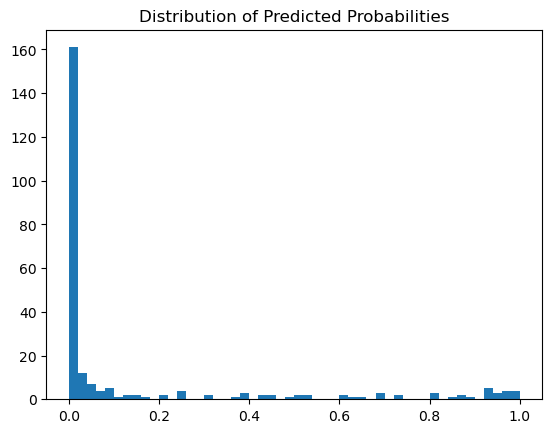

In [14]:
# Plotting the probabilities for inspection
plt.hist(predicted_probabilities, bins=50)
plt.title('Distribution of Predicted Probabilities')
plt.show()

In [15]:

# # Optional: Display some predictions along with their images
# import matplotlib.pyplot as plt
# import random

# num_images_to_display = 5
# sample_indexes = random.sample(range(len(test_features)), num_images_to_display)

# for i in sample_indexes:
#     plt.imshow(test_features[i].reshape(224, 224, 3))
#     plt.title(f'Predicted: {predicted_classes[i][0]}, Actual: {test_labels[i]}')
#     plt.show()